# U.S. Senators: A Voting Pattern Study

## Students

* Team: `18`
* Students: ` Quentin Bacuet, Ali Alami-Idrissi, Keshav Singh, Leandro Kieliger`
* Dataset: `US-Senators`

## Imports

In [1]:
# IPython magic to reload changes on external files
% load_ext autoreload
% autoreload 2

# Import general libs
import numpy as np
import pandas as pd
import scipy as sc
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import pickle

# Import specific modules
from scipy import sparse
from pygsp import graphs, reduction
from scipy import linalg
from pyunlocbox import functions, solvers
from sklearn.cluster import KMeans
from IPython.display import display, HTML
from IPython.display import Image
from ipywidgets import interact, interactive, fixed, interact_manual
from itertools import combinations
import ipywidgets as widgets
from sklearn.model_selection import KFold

# Import utility functions from external files
from utils import *
from plot_utils import *
from graph_utils import *
from cluster_utils import *
from request_utils import *
from transducive_learning_utils import *
from eval_utils import *

## Style settings

In [2]:
display(HTML("""
<style type="text/css">
div.output_png {
  display: flex;
  justify-content: center;
  margin-right:10%;
}
</style>
"""))

party_colormap = {'R':'red', 'D': 'dodgerblue', 'I':'limegreen'}

## Load processed data

In [3]:
np.random.seed(2018)

# Load a restricted set of votes
# This set contains ony the ones most easily interpretable for a person unfamiliar with american political matters
votes_restricted = pd.read_pickle("data/processed/processed_votes_1.pickle").fillna(0)
votes_restricted, _= split_dataframe(1, votes_restricted)
print("\n\n\nThe 1st vote dataframe is a " + str(votes_restricted.shape) + " table with senators as rows and vote positions as columns.")
display(votes_restricted.head(3))

# Bill descriptions
bill_descriptions = pd.read_csv("data/processed/processed_bill_descriptions.csv").set_index('bill_id')
print("\n\n\nBill descriptions is a " + str(votes_restricted.shape) + " table with senators as rows and vote positions as columns.")
display(bill_descriptions.head(3))

# Load full set of votes, including motions
votes_full = pd.read_pickle("data/processed/processed_votes_2.pickle").dropna(0)
print("\n\n\nThe 2nd vote dataframe is a " + str(votes_full.shape) + " table with roll call ID as rows and description as columns.")
display(votes_full.head(3))

# Loads the selected senators details
senators = pd.read_pickle("data/processed/processed_senators.pickle")
senators = senators.loc[senators.index.intersection(votes_full.index)]
print("\n\n\nThe senators dataframe is a " + str(senators.shape) + " table with senators as rows and ID, party and names as columns.")
display(senators.head(3))

#Load labels
senators_party = senators['party']
colorcode = np.vectorize({'R':'red','D':'dodgerblue','I':'limegreen'}.get)(senators_party)




The 1st vote dataframe is a (105, 23) table with senators as rows and vote positions as columns.


id,hr2-115-143-2,s722-115-147-1,sres584-115-162-2,hr1865-115-60-2,hr5515-115-128-2,s84-115-27-1,hr3364-115-175-1,hr2430-115-187-1,s2155-115-54-2,hconres71-115-245-1,...,sconres3-115-26-1,hr6157-115-193-2,sres176-115-138-1,s89-115-102-1,s2554-115-209-2,hr6147-115-180-2,treatydoc.114-12-115-98-1,hr5895-115-139-2,hr1-115-303-1,hr2810-115-199-1
member_id,,,,,,,,,,,,,,,,,,,,,
A000360,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
B000575,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
B000944,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,...,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0





Bill descriptions is a (105, 23) table with senators as rows and vote positions as columns.


,summary,summary_short
bill_id,,
hr695-115,NaN,NaN
pn2209-115,NaN,NaN
s756-115,Save Our Seas Act of 2017 or the SOS Act of 20...,Save Our Seas Act of 2017 or the SOS Act of 20...





The 2nd vote dataframe is a (96, 129) table with roll call ID as rows and description as columns.


id,hconres71-115-224-1,hconres71-115-227-1,hconres71-115-231-1,hconres71-115-234-1,hconres71-115-245-1,hjres111-115-249-1,hjres123-115-311-1,hjres37-115-81-1,hjres38-115-43-1,hjres40-115-66-1,...,sconres3-115-9-1,sjres34-115-94-1,sjres52-115-97-2,sjres54-115-266-2,sjres57-115-76-2,sjres63-115-226-2,sjres64-115-260-2,sres176-115-138-1,sres584-115-162-2,treatydoc.114-12-115-98-1
member_id,,,,,,,,,,,,,,,,,,,,,
A000360,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,1.0
B000575,0.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,1.0
B000944,1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0





The senators dataframe is a (96, 5) table with senators as rows and ID, party and names as columns.


,party,first_name,last_name,votes_with_party_pct,name
member_id,,,,,
A000360,R,Lamar,Alexander,96.91,Lamar Alexander
B000575,R,Roy,Blunt,98.12,Roy Blunt
B000944,D,Sherrod,Brown,93.36,Sherrod Brown


## Building the similarity graph

In our graph, nodes represent senators and edges between senators indicate how similar they tend to vote on roll calls made on the senate floor. We have 96 senators for which we have a full congress worth of data and more than 100 different roll calls.

We sparsify the graph by removing edges with weight below 0.25  and  keep  only  the  15  edges  with  highest  weight  per node.  The  reason  behind  this  design  choice  is  that  without imposing  limits  on  the  maximum  number  of  neighbors,  two clear clusters emerge immediately: republicans and democrats. Indeed, with  a  sparsification  threshold  of  0.75,  the  graph  is  already disconnected while the average clustering coefficient remains well  above  0.9.

In [4]:
def build_graph(df, edge_limit=0.25, neighbor_limit=20):
    '''
    Builds the adjacency matrix by computing the similarities between senators.
    This implementation can be used to feed various features matrices and apply a different distance function and
    sparsification function to each of them. A weighted average is then returned. Here, we only use the vote features
    '''
    features = df.values
    sparsification_function = lambda arg : sparsify_with_max_neighbors(sparsify_with_limit(arg, edge_limit), neighbor_limit)
    adjacency = get_adjacency_matrix(features, cosine_similarity, lambda x:x, sparsification_function)

    G= graphs.Graph(adjacency)
    G.compute_differential_operator()
    G.compute_fourier_basis()
    G.compute_laplacian()
    
    return adjacency,G

adjacency_restricted, G_restricted = build_graph(votes_restricted)
adjacency_full,G_full = build_graph(votes_full)

### Basic statistics about the graph

Clustering coefficient: 0.6362960076630743
Diameter: 6


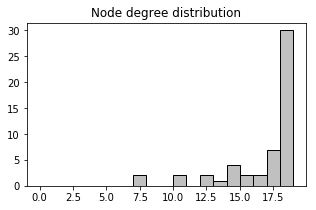

In [5]:
print_graph_specs(adjacency_full)

The  degree  distribution  is,  as  expected,  highly  skewed towards  the  maximum. The average clustering  coefficient is however reasonably small.

### The graph itself

We plot below the generated senators similarity graph using the networkx spring layout

Text(0.5,1,'Similarity graph')

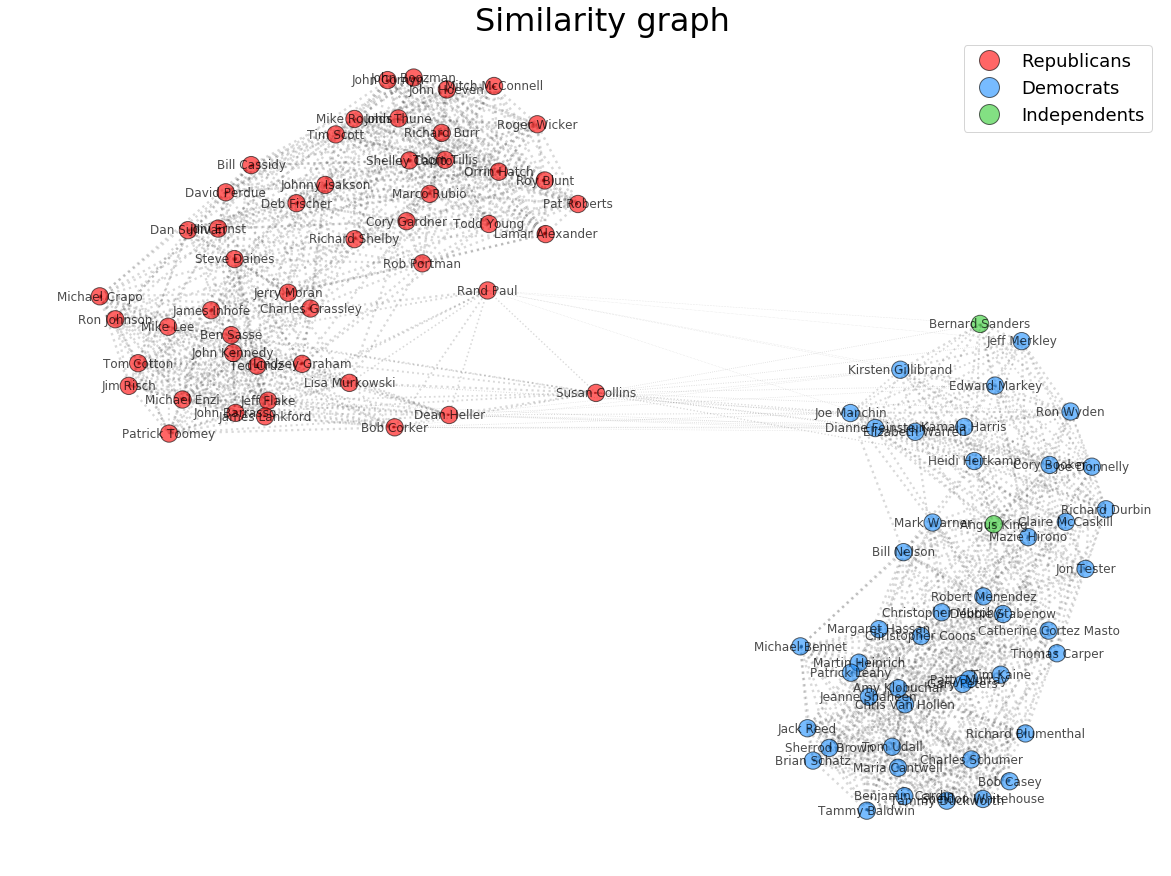

In [6]:
plot_signal(G_full.W.todense(), senators['party'].map(party_colormap), labels=senators['name'], scale=[0,1], k=5.0)
rh = mlines.Line2D([], [], color='red', marker='o', linestyle='', markeredgewidth=1, markeredgecolor='black', alpha=0.6, markersize=20, label="Republicans")
dh = mlines.Line2D([], [], color='dodgerblue', marker='o', linestyle='', markeredgewidth=1, markeredgecolor='black',  alpha=0.6,markersize=20, label="Democrats")
ih = mlines.Line2D([], [], color='limegreen', marker='o', linestyle='', markeredgewidth=1, markeredgecolor='black', alpha=0.6, markersize=20, label="Independents")

plt.legend(handles=[rh,dh,ih], prop={'size':18})
plt.savefig("similarity_graph.png")
plt.title('Similarity graph', fontsize=32)

## Political affiliation identification

Our first research question is to find whether we can use a similarity graph to identify the senators which are the closest to our own political opinions and if so, where do our opinions lie in the political continuum ? To do so, we need to collect a few vote samples where we indicate how we would have voted if we were to be a senator.

However, giving our opinion of every vote cast in the senate would be highly impractical. Therefore, we need to chose carefully the votes which will convey the highest information on our political stance.

To this end, we build a similarity graph where nodes correspond to roll calls and features to senators. This will hopefully help us distinguish subjects based on their "electoral basis". We finish by selecting the best representative among each category of vote.

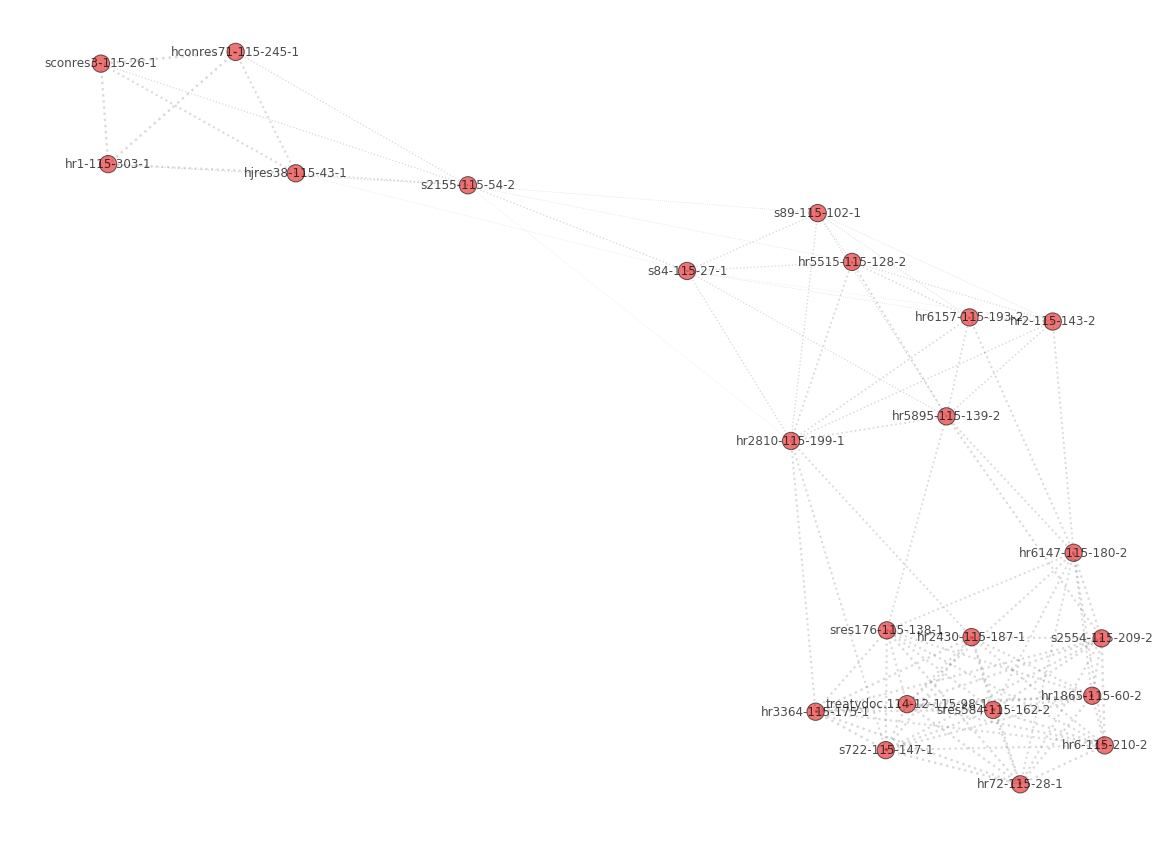

In [7]:
bill_cluster_count = 3

# Build adjacency matrix but this time where nodes are bills and features senators that voted for them
sparsification_functions = lambda arg : sparsify_with_limit(sparsify_with_max_neighbors(arg,10),0.7)

# build the graph object
G_bills = graphs.Graph(
    get_adjacency_matrix(votes_restricted.T.values, cosine_similarity, lambda x:x, sparsification_functions)
)

G_bills.compute_laplacian()
G_bills.compute_fourier_basis()
G_bills.compute_differential_operator() 

plot_signal(
    G_bills.W.todense(),
    np.array([1]*votes_restricted.shape[1]),
    labels = votes_restricted.columns)

## Identifying categories of votes

In order to select  the  3  initial  votes  to  consider  for  our  embedding,  we designed  5  different  algorithms  that  leverages  the  new  votes similarity  graph  and  its  feature  matrix  to  accomplish  this task. We describe below how they work and run them on our dataset:


In [8]:
# Track the combination of votes returned by each of the 5 methods
best_bills_per_method = []


### Method 1: Variance maximization
The most straightforward way to  find  influential  votes  is  to  look  for  the  ones  that generate  the  highest  variation  in  voting  positions.  For this purpose, we find votes feature vectors which yields the highest variance.

In [9]:
# variances holder
var = np.zeros(votes_restricted.shape[1])

for i in range(votes_restricted.shape[1]):
    # Compute the variance of votes by not considering neutral and non existant votes
    a = votes_restricted.values[:,i]
    var[i] = np.var(a[a != 0])

# Get the three votes with highest variance
best_bills = var.argsort()[-bill_cluster_count:]
best_bills_per_method.append(best_bills)

### Method 2: Intra-party variance maximization

Senators from the same political party tends to have similar voting positions. This means that method 1 might end up only capturing votes for which democrats and republicans disagree. A more robust way to identify influential votes is to look for the ones that creates the highest division inside the same party. This can be easily done by looking for the votes feature vectors that maximize the  inter-party variance. Formally, let $x_i$ be the feature vector for roll call vote $i$, $SD$ the set of democrat senators and $SR$ the set of republican senator. The mean inter-party variance for vote $i$ is computed as: 
    $$\text{InterVar}_i = \frac{Var(x_{i\{j_1,j_2,j_3...j_n\}})+Var(x_{i\{k_1,k_2,k_3...k_n\}})}{2}$$
    $$ \text{for}  \thinspace  j_i \in SD \And  k_i \in SR$$
    We then select vote $i$ such that: 
    $$i = \text{argmax}_i(\text{InterVar}_i)$$

In [10]:
# Variances holder
var = np.zeros(votes_restricted.shape[1])

# Get republicans and democrats votes separately 
rep_indexes = np.nonzero(senators_party == 'R')[0]
dem_indexes = np.nonzero(senators_party == 'D')[0] 
rep_data = votes_restricted.iloc[rep_indexes]
dem_data = votes_restricted.iloc[dem_indexes]

# Compute variances amoung republicans and democrat votes separately and average them
rep_std = np.apply_along_axis(lambda x : np.std(x[x!=0]),0,rep_data.values)
dem_data = np.apply_along_axis(lambda x : np.std(x[x!=0]),0,dem_data.values)
stds = (rep_std+dem_data)/2

# Get the three votes with the highest intra-party
best_bills = stds.argsort()[-bill_cluster_count:]
best_bills_per_method.append(best_bills)

### Method 3: Minimize the number of neighbors in the votes graph

An influential vote can be defined as a vote which is dissimilar to other votes in our dataset. Since our vote similarity graph is sparsified in such way that we only keep edges with high weight. We expect that an influential vote has a very small number of neighbors. Hence, the 3 initial votes can be found by simply selecting the nodes with the lowest degree in our  vote similarity graph.

In [11]:
# count the number of neighbors per nodes
temp = (G_bills.W.todense() > 0)
best_bills = np.asarray(temp.sum(0).argsort())[0][:bill_cluster_count]

# select the nodes with the smallest number of neighbors
best_bills_per_method.append(best_bills)

### Method 4: Finding the closest points to the bills clusters centers in the votes graph

The graph that we constructed in the beginning of this section already permits to visually identify three clear clusters of voting subjects. Such votes can be found by embedding their corresponding nodes in the 2-dimensional space spanned by the eigenvectors of the votes graph Laplacian. The clusters can be then identified using the K-Means algorithm. Finally, to obtain the influential bills we simply take the node (bill) that is the closest to the center of each cluster.

In [12]:
# Number of eigenvectors to take into account in our embedding 
embedding_dimension = 2

# Embedd all the bills and resolutions votes
embedding = G_bills.U[:,1:1+embedding_dimension]

# Run K-means and get the clusters and their centroids
clusters, centers = gen_kmeans(embedding, bill_cluster_count)
best_bills = np.zeros(bill_cluster_count)

# Find the closest votes to the clusters centers 
for j in range(bill_cluster_count):
    dist = np.linalg.norm(embedding - centers[j],axis=1)
    best_bills[j] = np.argmin(dist)
best_bills_per_method.append(best_bills.astype(int))

### Method 5: Select the most central nodes in the votes graph

An influential vote can be defined as a vote which is related to most of the other votes. Hence, a simple approach for finding a such votes is to select the ones with maximum degree in our votes graph. However, this measure will give an equal weight to all the graph links. One could argue that a "highly connected votes" should diffuse a fraction of its importance to his neighbors. That is, we would expect that a link that relates a highly connected vote in our graph to another similar vote should have more weight than a link which relates a weakly connected vote to another one. This importance metric can be computed using a well known graph centrality measure called PageRank. Hence, using the above definition, we can select the 3 most influential votes by keeping the ones that maximizes the PageRank score.

In [13]:
# Construct networkx graph object
nx_graph = nx.from_numpy_matrix(G_bills.W.todense())

# Compute the PageRank score per node
pagerank = nx.pagerank(nx_graph)
pagerank = np.array(list(pagerank.values()))

# Get the three votes with the highest pageRank score
best_bills = np.argsort(-pagerank)[:bill_cluster_count]
best_bills_per_method.append(best_bills)

### Votes selection methods evaluation

We defined multiple algorithms to select the most influent votes in our graph. Now we need a metric to compare their effectiveness. For this purpose, we measure their predictive power. That is, for each senator, by keeping the 3 selected votes as measured voting positions and predicting his position on the remaining votes using two distinct algorithms:

- **Transductive learning**: This method aims to predict the votes positions for every senator by minimizing label variation across edges.
- **K-nearest-Neighbors**: This method uses the selected votes to compute the distance between every pair of senators. The final prediction for missing votes corresponding to a senator is based on the voting pattern of its k most similar senators.

The final score for an algorithm is simply the mean accuracy obtained at the vote prediction task.

In [14]:
accuracies_trans_learning,accuracies_knn = find_best_votes(best_bills_per_method,votes_restricted,G_bills)

---------Transductive Learning benchmark------------
Best Method: 4
Accuracy: 0.9040984343468816
Votes idxs: [ 1 14 10]
Votes selected ['s722-115-147-1', 'hr6157-115-193-2', 'hjres38-115-43-1']
---------KNN benchmark------------
Best Value Index: 1
Accuracy: 0.9313129228299508
Votes idxs: [13 21  9]
Votes selected ['sconres3-115-26-1', 'hr1-115-303-1', 'hconres71-115-245-1']


In [15]:
## Detailed accuracy for every method
voting_methods = ['Variance Maximization','Intra-party variance Maximization','Neighbors minimization',
                  'Clusters centroids selection','PageRank score maximization']
results = pd.DataFrame([voting_methods,accuracies_trans_learning.tolist(),accuracies_knn.tolist()]).T
results.columns = ['Methods','Transductive learning score','KNN score']
results

,Methods,Transductive learning score,KNN score
0,Variance Maximization,0.598877,0.931313
1,Intra-party variance Maximization,0.607943,0.931313
2,Neighbors minimization,0.602437,0.931313
3,Clusters centroids selection,0.904098,0.928574
4,PageRank score maximization,0.870024,0.929658


Transductive learning and KNN does not agree on the best vote selection method. In fact,Transductive Learning selects votes that are output by bills clustering technique (Method 4) whereas KNN selects votes which are output by the variance maximization technique. However, we notice that the accuracy scores output by KNN are very close to each other. Hence, basing our evaluation solely on this numbers would not be rigorous. This is why we chose to select the best method selected by the transductive learning evaluation (Method 4).

### Selected bills

Here are the bills that were selected by this method and their position on the bills graph

============== INFORMATION REGARDING s722-115-147-1 ============== 

Roll call: 147
Session: 1

https://www.senate.gov/legislative/LIS/roll_call_lists/roll_call_vote_cfm.cfm?congress=115&session=1&vote=00147

RELATED BILL INFORMATION

Bill title: A bill to impose sanctions with respect to Iran in relation to Iran's ballistic missile program, support for acts of international terrorism, and violations of human rights, and for other purposes.

Bill url:  https://www.govtrack.us/congress/bills/115/s722

Short description: Countering Iran's Destabilizing Activities Act of 2017 This bill directs the Departments of State, Defense, and Treasury and the Director of National Intelligence to submit a strategy every two years for deterring conventional and asymmetric Iranian activities that threaten the United States and key allies in the Middle East, North Africa, and beyond.  The President shall impose asset blocking and U.S. exclusion sanctions against any person that materially contributes to

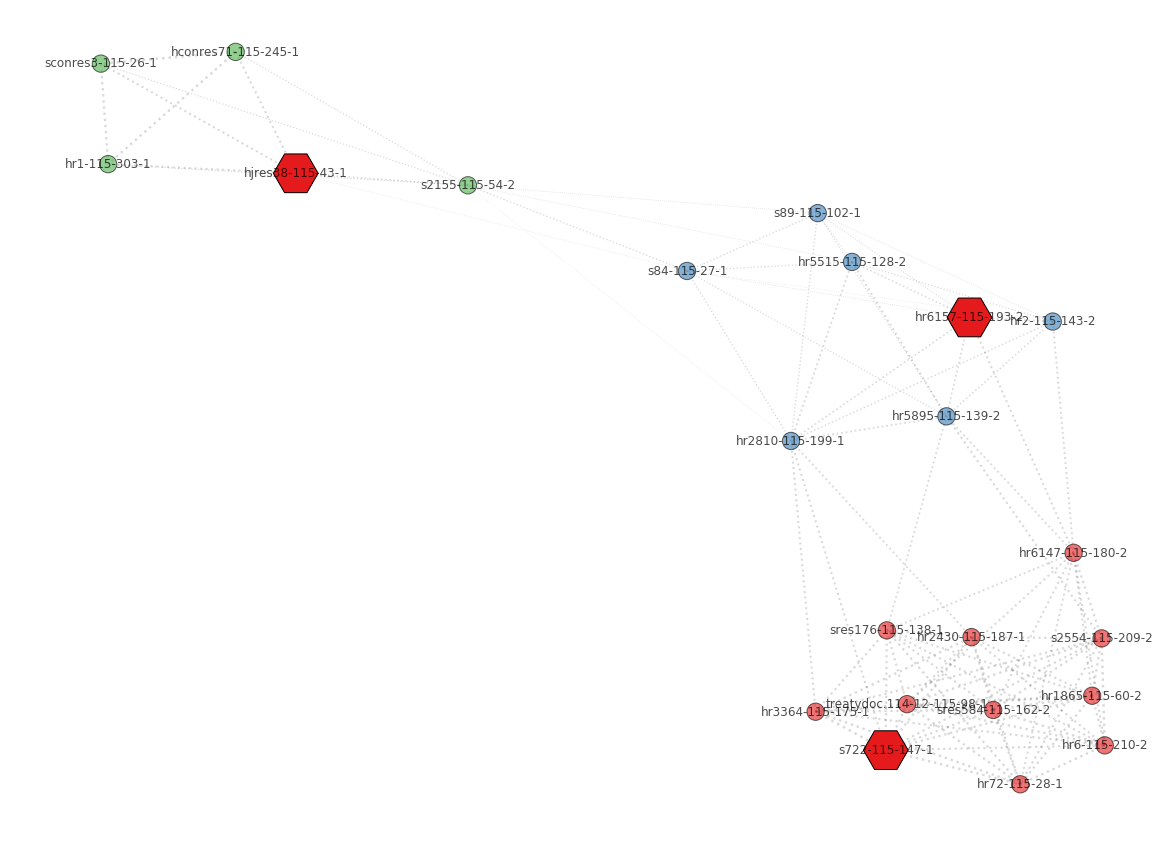

In [16]:
def print_selected_votes(votes_list,best_bills_idxs):
    """Pretty print a list of selected votes descriptions"""
    selected_votes_unique_ids = votes_list.iloc[:, best_bills_idxs].columns.values
    for v in selected_votes_unique_ids:
        print_info(v)
    bills = [x.split('-')[0] for x in selected_votes_unique_ids]
    return set(bills)

vote_selection = best_bills_per_method[3].astype(int)
plot_signal(G_bills.W.todense(), 
            clusters, 
            labels=votes_restricted.T.index, 
            scale=[0,9], 
            highlight_node=vote_selection,
            colormap=plt.get_cmap('Set1'))


print_selected_votes(votes_restricted, vote_selection)
plt.savefig("bill_selection.png", bbox_inches="tight")

## Where do we stand on the graph ? 
In this section, we use the votes and similarity graphs built above to model our political orientation.The widget below shows the senators that are likely to have similar political opinion, it also measure our position in the political continuum (liberal <-> conservative).

The picked votes are:

#### Countering Iran's Destabilizing Activities Act of 2017

This bill directs the President to impose sanctions against any person that materially contributes to Iran's ballistic missile or weapons of mass destruction programs.

#### Department of Defense and Labor, Health and Human Services, and Education Appropriations Act, 2019 and Continuing Appropriations Act, 2019

The bill provides 606.5 billion for the Department of Defense base budget for the fiscal year (FY) 2019, which is an increase of 17.1 billion above FY18 levels. This funding level is consistent with the National Defense Authorization Act as well as the recently enacted budget agreement.

#### Disapproving the rule submitted by the Department of the Interior known as the Stream Protection Rule.

Disapprove a rule that attempted to reduce the environmental impact of coal mining by establishing a buffer zone rule blocking mining within 100 feet of streams, and imposing stricter policies that required companies to restore land to pre-mining conditions.

Suppose I vote as follows:

1. No
2. Yes
3. No

My restricted feature vector becomes $v = [-1,1,-1]$. Computing the similarity of this vector with the other senators results in the following embedding (note that these positions would be categorized as "leaning-democratic". A "hardcorde" democratic vote here would be $[1,1-1]$):

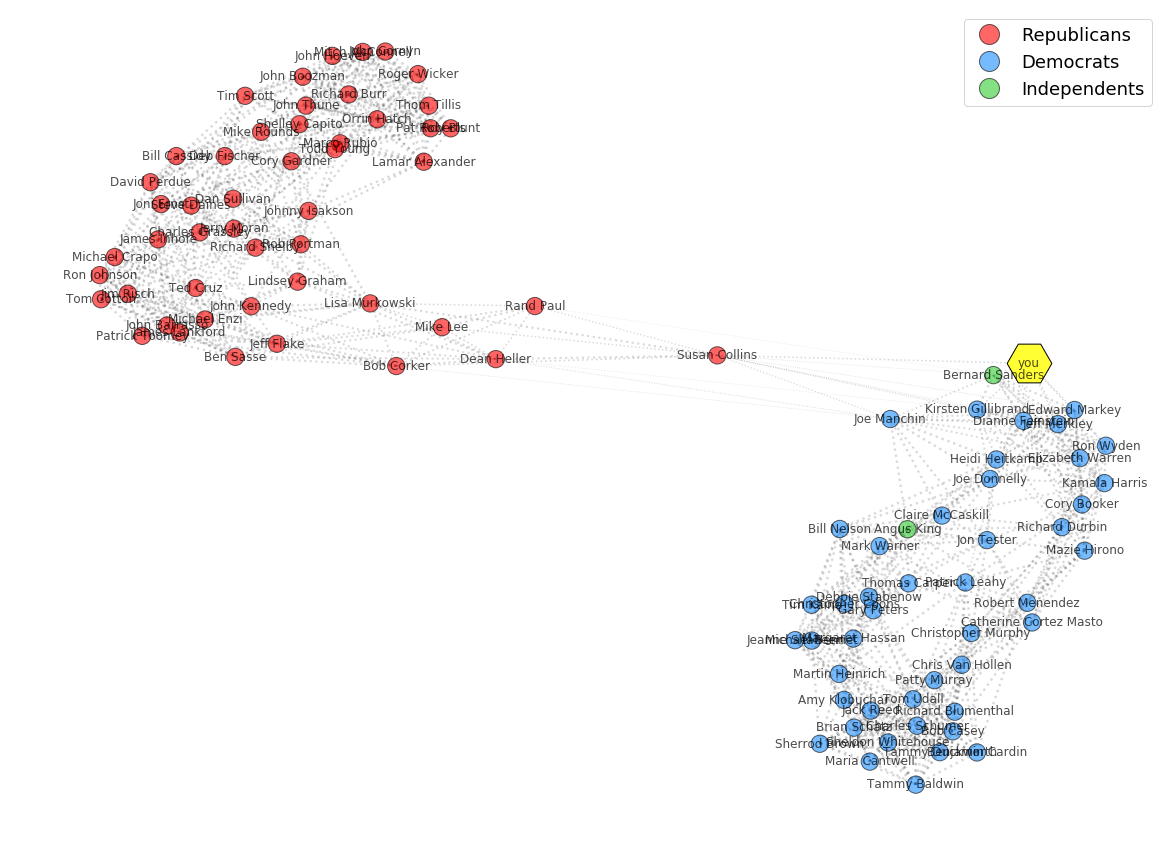

In [17]:
my_votes = [-1,1,-1]

def compute_similarity(senator_votes,your_votes):
    """Compute the cosine similarity between your_votes and other senators votes"""
    return cosine_similarity(senator_votes, your_votes)

def get_extended_graph(v):
    ## Get the selected votes indices in the full feature matrix
    seed_votes_idxs = [np.nonzero(votes_full.columns == votes_restricted.columns[x])[0][0] for x in vote_selection]
    other_senators_vote = votes_full.values[:,seed_votes_idxs]

    # Compute similarity on the restricted set of features
    similarity_vector = np.apply_along_axis(compute_similarity, 1, other_senators_vote, v)
    similarity_vector[np.isnan(similarity_vector)] = 0
    similarity_vector =sparsify_with_limit(similarity_vector,0.51)

    top_similar = similarity_vector.argsort()[-3:][::-1]
    similar_senators = senators.iloc[top_similar]

    # Build the new adjacency matrix
    new_adjacency = append_new_column(adjacency_full, np.append(similarity_vector, 0))
    new_adjacency = sparsify_with_max_neighbors(new_adjacency,15)

    G_extended = graphs.Graph(new_adjacency)
    G_extended.compute_fourier_basis()
    G_extended.compute_laplacian()
    G_extended.compute_differential_operator()
    
    return new_adjacency, G_extended, similar_senators

new_adjacency, G_extended, similar_senators = get_extended_graph(my_votes)

plot_signal(
    new_adjacency, 
    senators['party'].map(party_colormap), 
    labels=np.append(senators['name'].values, ['you']), 
    scale=[0,1], 
    highlight_node=[len(new_adjacency)-1], 
    k=3.25)

plt.legend(handles=[rh,dh,ih], prop={'size':18})
plt.savefig("extended_graph.png", bbox_inches='tight')

### Putting some faces to the nodes

Let's see who are the senators whose votes showed the most similarity with our own political position. We also illustrate the coordinate of our own embedding in the 2D space given by the Laplacian eigenmap.

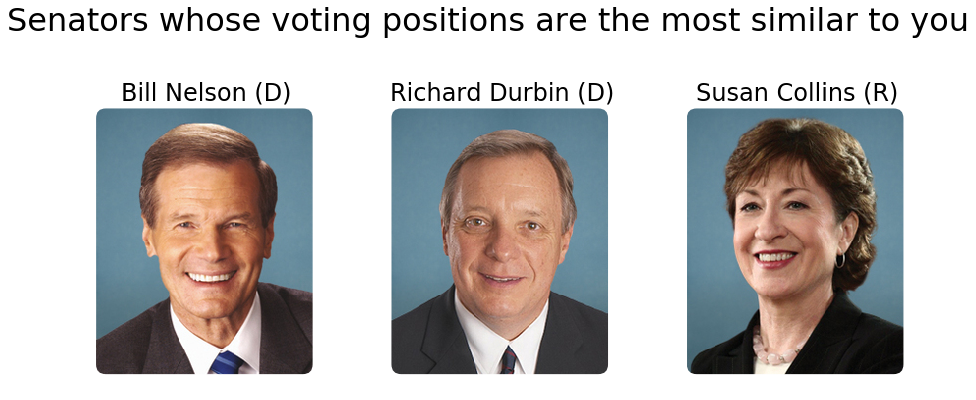

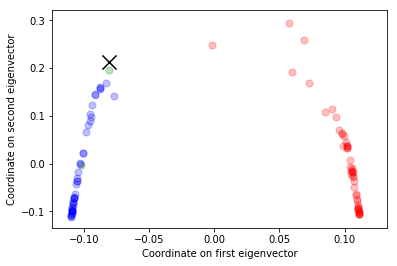

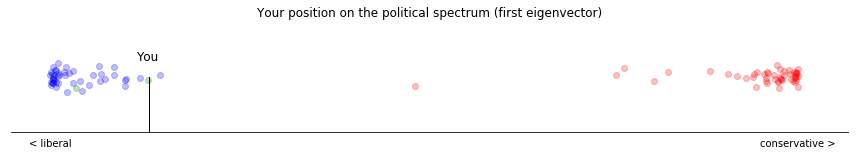

In [18]:
show_portraits(similar_senators)    

colors = {0:'red',1:'blue',2:'green', 3:'orange'}
show_2D_embedding(G_extended.U[:,1:3], senators_party)

show_political_spectrum(G_extended.U[:,1:3], colors, senators_party)

Here's what whould happen on a set of four different vote combinations. For an interpretation, please refer to the report.

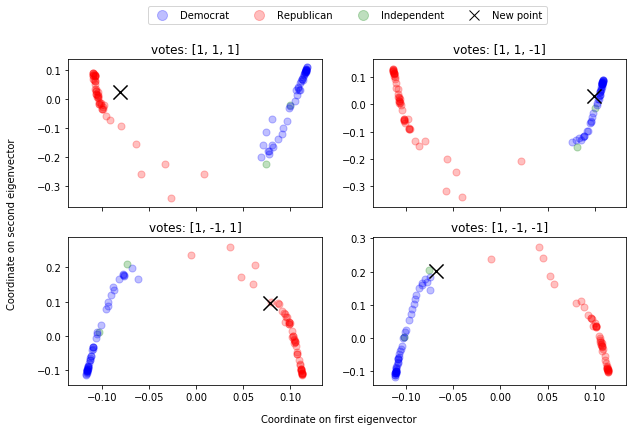

In [19]:
selections = [[1,1,1],[1,1,-1],[1,-1,1],[1,-1,-1]]
embeddings = []
for sel in selections:
    
    _, G_ext, _ = get_extended_graph(sel)
    embeddings.append(G_ext.U[:,1:3])
    
plot_embeddings(embeddings, selections, senators_party)

## Vote predictions using Transductive learning
We use below the new similarity graph which contains our voting positions in order to predict your voting outcome on new subjects using transductive learning. A short interpretation is available in the report.

In [20]:
def predict_your_votes(G, votes, vote_id):
    
    positions = votes[vote_id]
    
    # Build a subgraph from your direct neighbors
    adj = G_extended.W.todense()
    neighbors_indices = np.nonzero(adj[-1])[1]
    subgraph_indices = np.append(neighbors_indices, [len(adj)-1])
    subG = G.subgraph(subgraph_indices)
    subG.compute_differential_operator()
    
    bill_votes = np.append(positions, 0)[subgraph_indices]
    
    print(positions.values[neighbors_indices])
    
    # Create a mask where all the neighbors are measured
    measure_mask = np.append(np.ones(len(bill_votes)-1), 0)    
    
    labels_bin = get_thresholded_values(bill_votes,0)
    sol, sol_binarized = reconstruct_signal(subG, measure_mask, labels_bin)    
    print("On "+ vote_id +" you would have voted " + str(sol_binarized[-1]) + " ("+str(sol[-1])+")")


#print_info_short('hconres71-115-224-1')
predict_your_votes(G_extended, votes_full, 'hconres71-115-224-1')


#print_info_short('s2155-115-53-2')
predict_your_votes(G_extended, votes_full, 's2155-115-53-2')

[-1.  1.  1.  1.  1.  1.  1.  1.  1.]
On hconres71-115-224-1 you would have voted 1.0 (0.9748201392330291)
[ 1. -1. -1. -1. -1. -1. -1. -1. -1.]
On s2155-115-53-2 you would have voted -1.0 (-1.0134103047271183)


# Going further, can we predict the voting outcome based on votes of swing senators ?

Swing senators are those that link the democratic and republican clusters. In this part we would like to see whether we can accurately predict the outcome of a vote (passed/rejected) only by looking at the swing senators voting positions. For this purpose, we use the full feature matrix defined in the feature engineering notebook. The latter contains all the votes on bills, resolution and motions passage. We divide the collected votes into a training and test set using a 80:20 split.

(96, 26)
(96, 103)


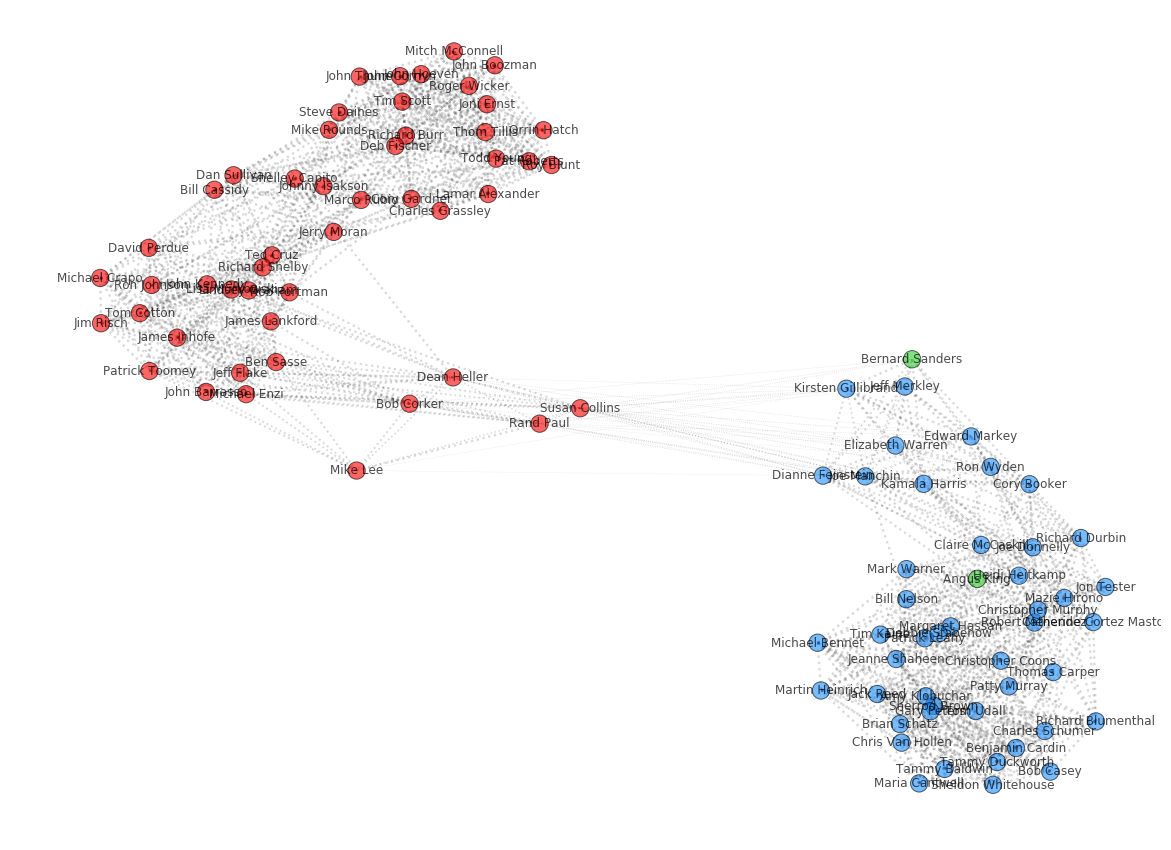

In [21]:
np.random.seed(2018)
votes_train, votes_test = split_dataframe(0.8, votes_full)

print(votes_test.shape)
print(votes_train.shape)

adjacency_pred , G_pred = build_graph(votes_train, 0.25, 20)

plot_signal(G_pred.W.todense(), senators['party'].map(party_colormap), labels=senators['name'], k=4.5)
plt.show()

We identify swing senators by defining a score which measures how closely they are related to senators from another political party. This done using the following formula
$$Score_i = \frac{\Sigma_{j \in A_i}W_{ij}}{\Sigma_{j=1}^n W_{ij}}$$
where W is the similarity graph adjacency matrix and $A_i$ is the set of senators which are not in the same party of senator i.

The swing senators are:

In [22]:
## Identifying swing votes
def swing_scores(adjacency,labels):
    """
    Compute the swing score for every senator
    
    Parameters
    ----------
    adjacency : ndarray
        similarity graph adjacency matrix
    labels : array
        Senators political affiliation (Republican,Democrat,Independant)
        
    Returns
    -------
    numpy.array
    The swing score for every senator
        
    """
    similarity_mask = (np.repeat(labels[np.newaxis,:],adjacency.shape[0],axis=0) != labels [:,np.newaxis])
    weights_sum = adjacency.sum(1)
    swing_score = (similarity_mask*adjacency).sum(1)
    swing_score /= weights_sum
    return swing_score  

def get_swing_senators(G,senators_party,threshold=0.0):
    ''' return the list of selected swing senators '''
    parties = senators_party.copy()
    parties[parties == 'I'] = 'D'
    swing_senators = np.nonzero(swing_scores(np.asarray(G.W.todense()),parties) > threshold)[0]
    non_swing_senators = np.nonzero(swing_scores(G.W.todense(),parties) <= threshold)[0]
    return swing_senators,non_swing_senators

swing_senators, non_swing_senators = get_swing_senators(G_pred,senators_party,threshold=0.1)
print(senators['name'].iloc[swing_senators])

member_id
C001035         Susan Collins
C001071            Bob Corker
F000062      Dianne Feinstein
G000555    Kirsten Gillibrand
H001041           Dean Heller
M001183           Joe Manchin
P000603             Rand Paul
S000033       Bernard Sanders
W000817      Elizabeth Warren
Name: name, dtype: object


### Predicting the outcome on unseen votes
We now perform transductive learning by using the swing senators as the measured nodes and the rest as what needs to be interpolated

In [23]:
 a = predict_and_compare(G_pred, votes_test, swing_senators)

Ground truth: {-1: 33, 1: 63}           Prediction: {-1: 16, 0: 9, 1: 71}     Correct outcome: True
Ground truth: {-1: 2, 1: 94}            Prediction: {-1: 1, 1: 95}            Correct outcome: True
Ground truth: {-1: 24, 0: 7, 1: 65}     Prediction: {-1: 1, 0: 1, 1: 94}      Correct outcome: True
Ground truth: {-1: 51, 0: 1, 1: 44}     Prediction: {-1: 50, 1: 46}           Correct outcome: True
Ground truth: {-1: 49, 1: 47}           Prediction: {-1: 49, 1: 47}           Correct outcome: True
Ground truth: {-1: 49, 0: 2, 1: 45}     Prediction: {-1: 49, 1: 47}           Correct outcome: True
Ground truth: {-1: 43, 0: 1, 1: 52}     Prediction: {-1: 47, 1: 49}           Correct outcome: True
Ground truth: {-1: 8, 1: 88}            Prediction: {-1: 1, 1: 95}            Correct outcome: True
Ground truth: {-1: 39, 0: 3, 1: 54}     Prediction: {-1: 29, 0: 10, 1: 57}    Correct outcome: True
Ground truth: {-1: 49, 1: 47}           Prediction: {-1: 49, 1: 47}           Correct outcome: True


We plot below an example of a prediction that worked as well as one that did not.

============== INFORMATION REGARDING hr1-115-308-1 ============== 
Bill title: To provide for reconciliation pursuant to title II of the concurrent resolution on the budget for fiscal year 2018.

Bill url:  https://www.govtrack.us/congress/bills/115/hr1


Error binarized: 0.30779350562554625
Accuracy binarized: 0.96875


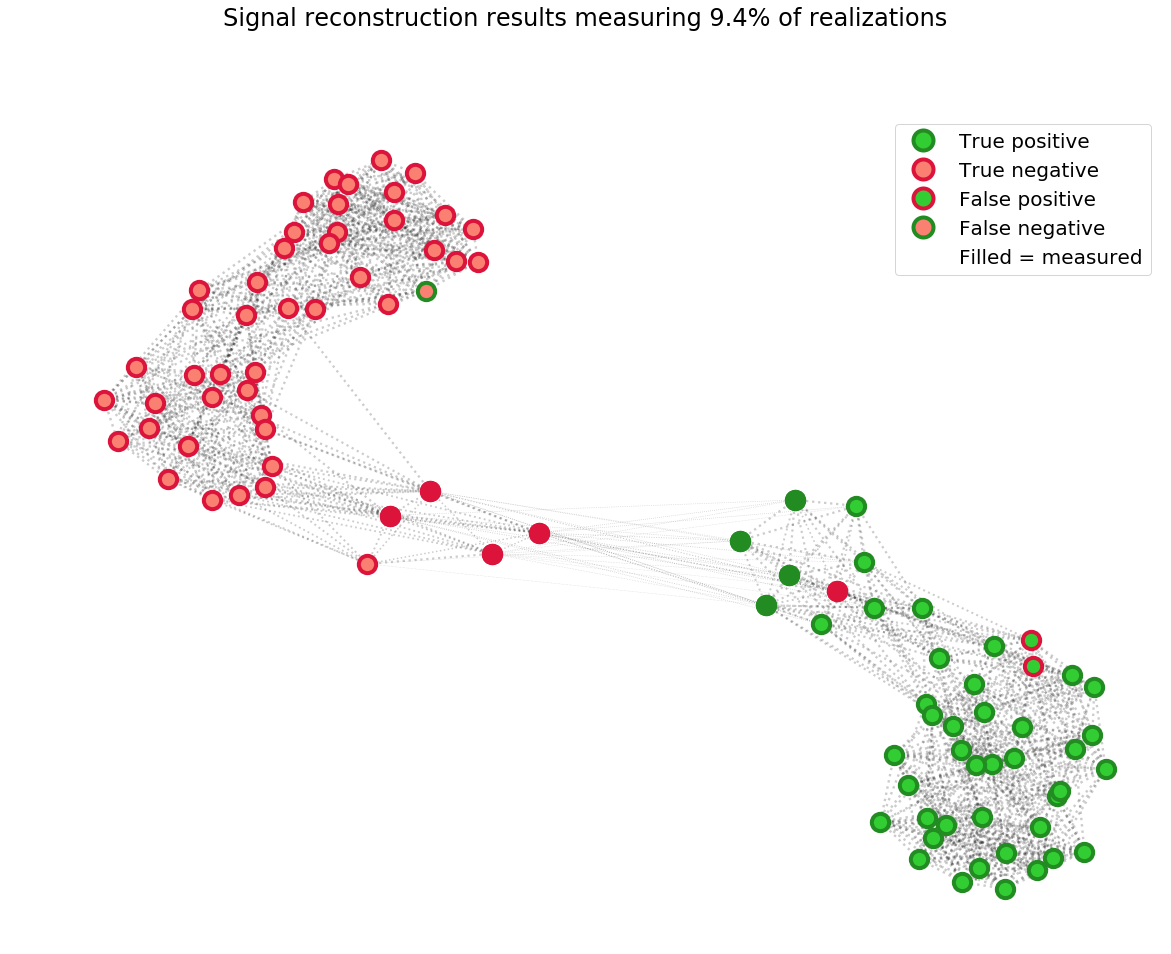

In [24]:
def show_prediction(index, votes_idx):
    ''' select a vote and predict its outcome using transductive learning and the swing senators votes '''
    labels_bin = get_thresholded_values(votes_test.values[:,index], threshold=0)
    print_info_short(votes_test.columns[index])
        
    mask = np.zeros(votes_test.shape[0])
    mask[votes_idx] = 1
    
    sol, sol_bin =  reconstruct_signal(G_pred,mask,labels_bin)
    plot_prediction(G_pred, sol_bin, labels_bin, mask)

    print("Error binarized: " + str(error(labels_bin, sol_bin)))
    print("Accuracy binarized: " + str(accuracy(labels_bin, sol_bin)))
    
# Sucess case
show_prediction(3, swing_senators)

============== INFORMATION REGARDING hr244-115-121-1 ============== 
Bill title: To encourage effective, voluntary private sector investments to recruit, employ, and retain men and women who have served in the United States military with annual presidential awards to private sector employers recognizing such efforts, and for other purposes.

Bill url:  https://www.govtrack.us/congress/bills/115/hr244


Error binarized: 1.1311807514597825
Accuracy binarized: 0.6666666666666666


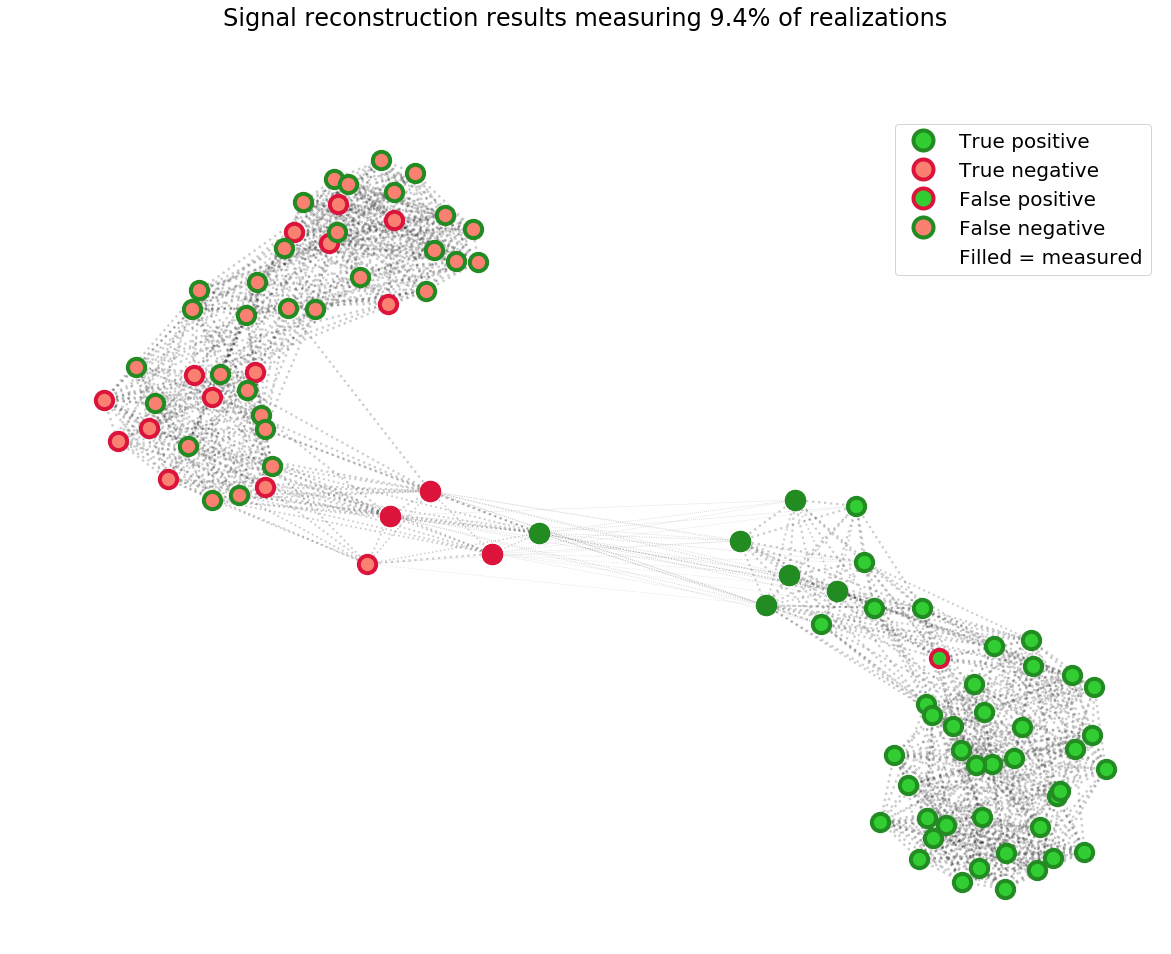

In [25]:
# Failure case
show_prediction(11, swing_senators)

How does this compare to a different selection with the same number of measured senators, but this time taken uniformly at random ? 

In [26]:
np.random.seed(1)
random_senators = np.random.choice(len(senators), len(swing_senators), replace=False)
print(senators[['name', 'party']].iloc[random_senators])
a = predict_and_compare(G_pred, votes_test, random_senators)

                      name party
member_id                       
H001046    Martin Heinrich     D
F000444         Jeff Flake     R
I000055     Johnny Isakson     R
M001111       Patty Murray     D
S000770    Debbie Stabenow     D
R000605        Mike Rounds     R
N000032        Bill Nelson     D
H001076    Margaret Hassan     D
S001184          Tim Scott     R
Ground truth: {-1: 33, 1: 63}           Prediction: {-1: 2, 1: 94}            Correct outcome: True
Ground truth: {-1: 2, 1: 94}            Prediction: {1: 96}                   Correct outcome: True
Ground truth: {-1: 24, 0: 7, 1: 65}     Prediction: {-1: 49, 0: 1, 1: 46}     Correct outcome: False
Ground truth: {-1: 51, 0: 1, 1: 44}     Prediction: {-1: 49, 1: 47}           Correct outcome: True
Ground truth: {-1: 49, 1: 47}           Prediction: {-1: 49, 1: 47}           Correct outcome: True
Ground truth: {-1: 49, 0: 2, 1: 45}     Prediction: {-1: 49, 1: 47}           Correct outcome: True
Ground truth: {-1: 43, 0: 1, 1: 52} 

============== INFORMATION REGARDING hr1-115-308-1 ============== 
Bill title: To provide for reconciliation pursuant to title II of the concurrent resolution on the budget for fiscal year 2018.

Bill url:  https://www.govtrack.us/congress/bills/115/hr1


Error binarized: 0.36992175559590695
Accuracy binarized: 0.9583333333333334


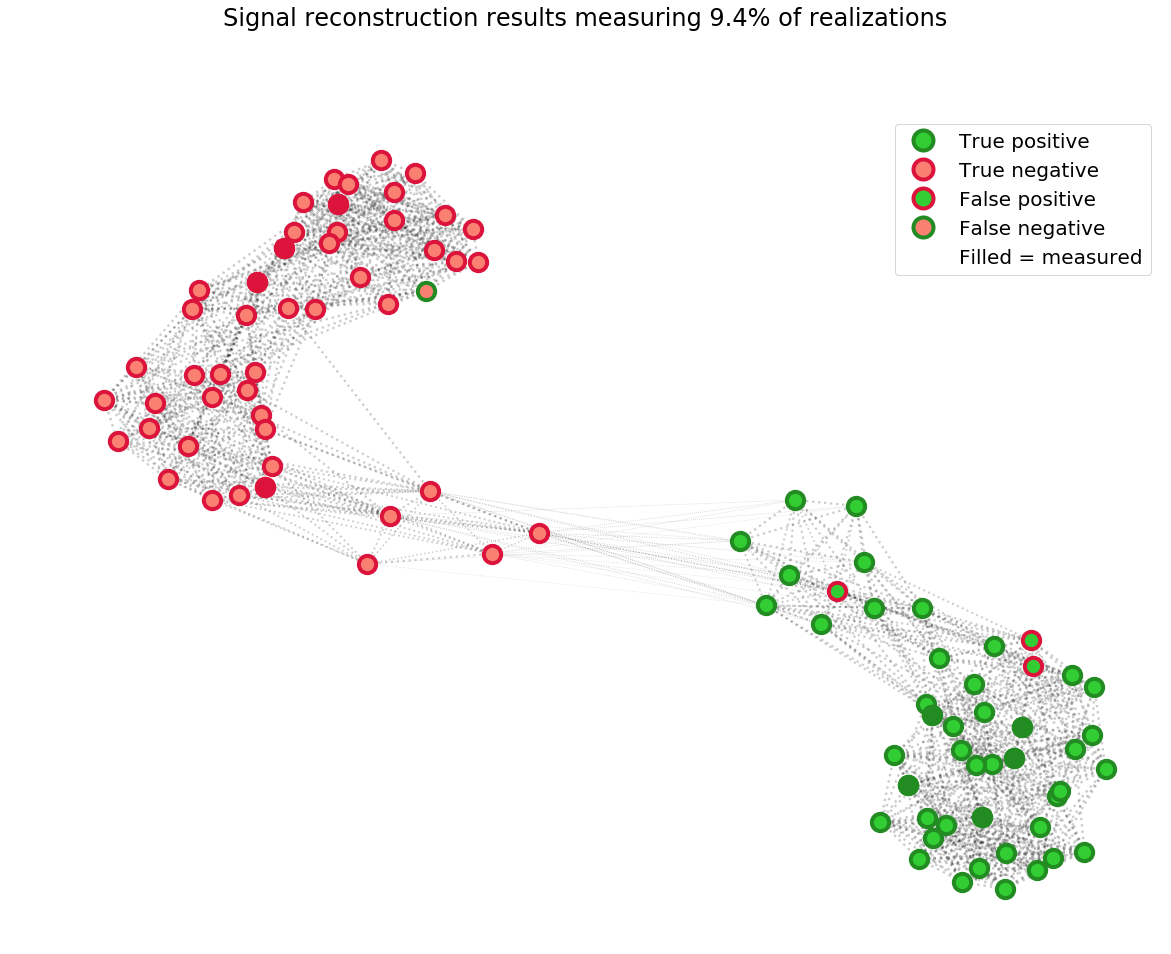

In [27]:
# Sucess case
show_prediction(3, random_senators)

============== INFORMATION REGARDING hr6157-115-192-2 ============== 
Bill title: Making appropriations for the Department of Defense for the fiscal year ending September 30, 2019, and for other purposes.

Bill url:  https://www.govtrack.us/congress/bills/115/hr6157


Error binarized: 1.0056022847309865
Accuracy binarized: 0.71875


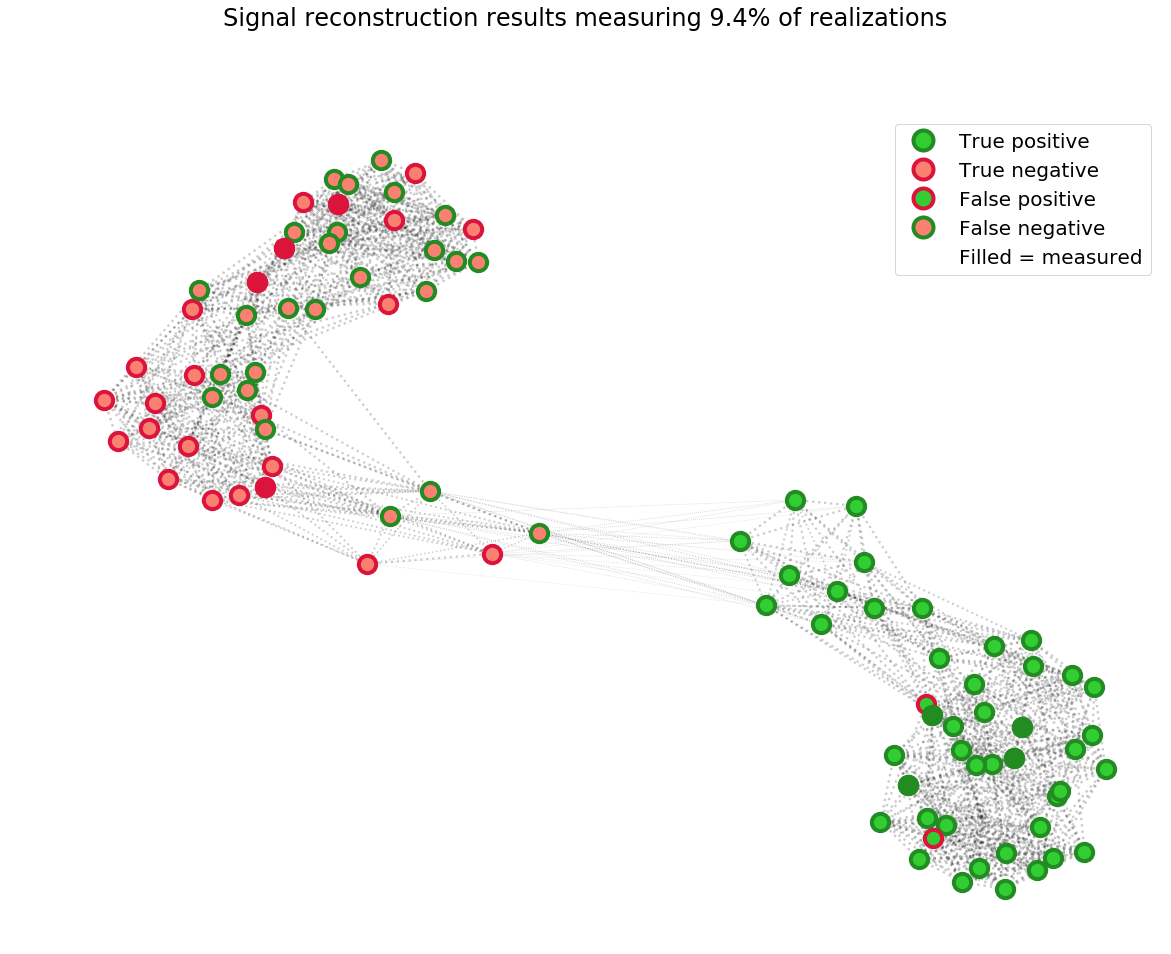

In [28]:
# Failure case
show_prediction(2, random_senators)

### 5-fold cross validation

To be more confident on our results, we perform 5-fold cross validation. Each time, splitting the vote dataset into two parts, 80% for building the similarity graph and 20% for the trying to predict the outcome based on the similarity graph. The results are shown below:

In [29]:
def kfold_predict_compare(k,senators,votes):
    """ 
    Perform K-fold cross validation to report the best accuracy at predicting roll call votes outcome.
    The senators similarity graph is built k time, every time with a different set of kept roll call votes (training votes).
    The outcome prediction accuracy is then computed using the left out roll call votes.
    """
    np.random.seed(2018)
    kfold = split_dataframe_into_chunks(k,votes)
    res = []
    print("---")
    for i,elem in enumerate(kfold):
        votes_train = pd.concat([*kfold[0:i],*kfold[i+1:len(kfold)]],axis=1)
        votes_test = elem         
        adjacency_pred , G_pred = build_graph(votes_train, 0.25, 20)
        a, _ = predict_and_compare(G_pred, votes_test, senators,False)
        print("{}th Accuracy: {}".format(i+1,np.mean(a)))
        res.append(np.mean(a))
    print("---")
    return res

In [30]:
kfold_swing_full = kfold_predict_compare(5,swing_senators,votes_full)

---
1th Accuracy: 0.9082532051282051
2th Accuracy: 0.8425480769230769
3th Accuracy: 0.8878205128205128
4th Accuracy: 0.9354967948717949
5th Accuracy: 0.9133333333333333
---


In [31]:
kfold_random_full = kfold_predict_compare(5,random_senators,votes_full)

---
1th Accuracy: 0.9310897435897435
2th Accuracy: 0.8866185897435895
3th Accuracy: 0.9543269230769231
4th Accuracy: 0.9415064102564101
5th Accuracy: 0.9391666666666666
---


In [32]:
print("Swing senators: Mean of {} and Std of {}".format(np.mean(kfold_swing_full),np.std(kfold_swing_full)))
print("Random senators: Mean of {} and Std of {}".format(np.mean(kfold_random_full),np.std(kfold_random_full)))

Swing senators: Mean of 0.8974903846153846 and Std of 0.03137989211305479
Random senators: Mean of 0.9305416666666666 and Std of 0.023194360194644843


The  5-fold  cross-validation  shows  that  the  swing  senators selection doesn’t seems to predict more accurately the outcome of the votes than senators sampled uniformly a random on the graph. A possible explanation of this results is provided in our report